In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.metrics import recall_score, precision_score,confusion_matrix,\
        roc_auc_score, f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, precision_recall_curve,\
        fbeta_score, accuracy_score
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique

In [8]:
provider4 = pd.read_csv('provider4.csv')
provider4.sample(5)

,Unnamed: 0,Provider,PotentialFraud,patient_count,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,days_admitted,coverage,totalamount_charged,revenue_day,annual_amount,claimdiag,diag_grp,duplicate_claims,patient_duplicate_count,inpatient,outpatient
1572,1572,PRV52949,0,51,46.0,4.0,1.0,0.0,27.0,24.0,71.0,1,1,0.0,5.0,79,2.0,0.972785,347.468354,263.786920,9380.151899,19.0,0.0,36.0,0.0,0,1
2012,2012,PRV53510,0,12,7.0,5.0,0.0,0.0,5.0,7.0,67.0,1,3,0.0,5.0,16,6.0,0.974646,1001.000000,206.874042,5365.750000,4.0,2.0,6.0,0.0,0,0
2291,2291,PRV53857,0,10,10.0,0.0,0.0,0.0,4.0,6.0,76.0,1,2,0.0,6.0,10,8.0,0.882914,15068.000000,2321.755065,32554.200000,9.0,10.0,0.0,0.0,1,0
1020,1020,PRV52275,0,57,52.0,3.0,1.0,1.0,22.0,35.0,74.0,1,1,0.0,5.0,101,2.0,0.983824,272.178218,236.576778,6113.663366,16.0,0.0,37.0,0.0,0,1
4505,4505,PRV56637,0,137,103.0,10.0,7.0,17.0,49.0,88.0,73.0,3,65,1.0,5.0,161,3.0,0.982989,252.670807,151.116657,7364.236025,29.0,0.0,76.0,0.0,0,1


In [9]:
x = provider4.drop(['Unnamed: 0','Provider','PotentialFraud'],axis=1)
y = provider4['PotentialFraud']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x), y, test_size=0.3, random_state=100)
x.shape, y.shape

((5410, 24), (5410,))

In [134]:
#Confusion Matrix Plotting Function
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.4%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap='coolwarm');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Potential Fraud'])
    return

## SMOTE 

In [10]:
#SMOTE
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

In [11]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(StandardScaler().fit_transform(x_smote), y_smote, 
                                                                test_size=0.3, random_state=100)

In [137]:
def evaluate_model_stratified(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),
                   LinearSVC(),GaussianNB(),LinearDiscriminantAnalysis(),RandomForestClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    
    for classifier in classifiers:
        kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state= 100)
        model = Pipeline(steps = [('classifier', classifier)])
        str_cv= GridSearchCV(estimator= model, scoring='roc_auc', cv=kfold, param_grid = {})
        str_cv.fit(X_train, y_train)
    
        
        
        predicted_train = str_cv.predict(X_train)
        predicted_test = str_cv.predict(X_test)
    
    
        print(type(classifier).__name__)
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        print('Precision Score for test data {:.3f}'.format(precision_score(y_test, predicted_test)))
        print('Recall Score for test data {:.3f}'.format(recall_score(y_test, predicted_test)))
        print('f1 score for test data{:.3f}'.format(f1_score(y_test, predicted_test)))
        print('fbeta0.2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 0.5)))
        print('fbeta2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 2)))
        print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test, predicted_test)))
        print('Confusion matrix for train data')
        print(confusion_matrix(y_train, predicted_train))
        print('Confusion matrix for test data')
        print(confusion_matrix(y_test, predicted_test))
        print('-' *50)

In [10]:
evaluate_model_stratified(X_train_sm, X_test_sm, y_train_sm, y_test_sm)

LogisticRegression
Accuracy Score for train data: 0.891
Accuracy Score for test data: 0.893
Precision Score for train data 0.883
Precision Score for test data 0.890
Recall Score for train data 0.902
Recall Score for test data 0.898
f1 score for train data0.892
f1 score for test data0.894
fbeta0.2_score for train data0.886
fbeta0.2_score for test data0.892
fbeta2_score for train data0.898
fbeta2_score for test data0.897
ROC-AUC Score for train data: 0.891
ROC-AUC Score for test data: 0.893
Confusion matrix for train data
[[3036  410]
 [ 336 3083]]
Confusion matrix for test data
[[1293  165]
 [ 151 1334]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the num

LinearSVC
Accuracy Score for train data: 0.893
Accuracy Score for test data: 0.894
Precision Score for train data 0.878
Precision Score for test data 0.886
Recall Score for train data 0.911
Recall Score for test data 0.906
f1 score for train data0.894
f1 score for test data0.896
fbeta0.2_score for train data0.885
fbeta0.2_score for test data0.890
fbeta2_score for train data0.904
fbeta2_score for test data0.902
ROC-AUC Score for train data: 0.893
ROC-AUC Score for test data: 0.894
Confusion matrix for train data
[[3015  431]
 [ 306 3113]]
Confusion matrix for test data
[[1285  173]
 [ 140 1345]]
--------------------------------------------------
GaussianNB
Accuracy Score for train data: 0.730
Accuracy Score for test data: 0.742
Precision Score for train data 0.889
Precision Score for test data 0.902
Recall Score for train data 0.523
Recall Score for test data 0.547
f1 score for train data0.658
f1 score for test data0.681
fbeta0.2_score for train data0.779
fbeta0.2_score for test data0.7

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:15:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:16:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
Accuracy Score for train data: 1.000
Accuracy Score for test data: 0.961
Precision Score for train data 1.000
Precision Score for test data 0.957
Recall Score for train data 1.000
Recall Score for test data 0.965
f1 score for train data1.000
f1 score for test data0.961
fbeta0.2_score for train data1.000
fbeta0.2_score for test data0.959
fbeta2_score for train data1.000
fbeta2_score for test data0.963
ROC-AUC Score for train data: 1.000
ROC-AUC Score for test data: 0.961
Confusion matrix for train data
[[3446    0]
 [   0 3419]]
Confusion matrix for test data
[[1394   64]
 [  52 1433]]
--------------------------------------------------


## Hyperparameter tuning and Grid search for gradient classifier

In [31]:
#parameters for gradient classifier
gbc = GradientBoostingClassifier()
parameters = {
    "n_estimators":[50,100,200],
    "max_depth":[1,3,5],
    "learning_rate":[0.01,0.1,1],
    "subsample": [0.3, 0.9, 1.0]
}

clf= GridSearchCV(gbc,parameters,cv=5)
clf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...=None,
           

In [18]:
#GBC model
gbc2 = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200, subsample= 0.9)

In [20]:
# clf.best_params_
# {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
clf_best = gbc2.fit(X_train_sm, y_train_sm)

In [21]:
GradBoo_top15_features = pd.DataFrame(zip(x.columns, list(clf_best.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)
GradBoo_top15_features

,feature,coef
19,diag_grp,0.511205
21,patient_duplicate_count,0.110478
18,claimdiag,0.075376
4,Race5,0.036073
11,chronic_mean,0.028409
3,Race3,0.027062
12,claim_count,0.026506
13,days_admitted,0.023471
10,no_phy,0.021110
15,totalamount_charged,0.019880


Text(0, 0.5, '')

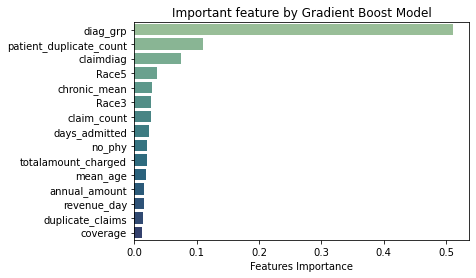

In [22]:
ax = sns.barplot(x="coef", y="feature", data=GradBoo_top15_features ,palette="crest")
ax.set_title('Important feature by Gradient Boost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [25]:
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.4%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap='coolwarm');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Potential Fraud'])
    return

In [23]:
predicted_test = clf_best.predict(X_test_sm)

Accuracy Score: 0.9602446483180428
F1 Score: 0.9606193200942443


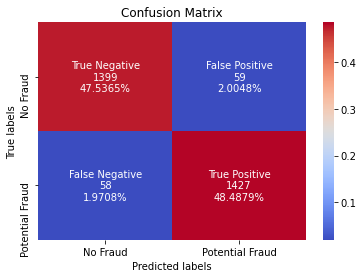

In [26]:
print(f'Accuracy Score: {accuracy_score(y_test_sm,predicted_test)}')
print('F1 Score: {}'.format(f1_score(y_test_sm, predicted_test)))
conf_mat(y_test_sm, predicted_test)

In [174]:
#Claims per provider
n = provider4['claim_count'].mean()

#cost based on non-oversampled train-test split of 1527 Negatives and 96 Positives
Neg = 1527
Pos = 96
#Average cost per fraudulent claim is the mean of InscClaimAmtReimbursed when PotentialFraud = "Yes", $1389.51
c = 998

# 29.17 = average hourly pay for a claims adjuster via https://www.indeed.com/career/claims-adjuster/salaries
i = 2 * 29.17 #cost to investigate a claim, assuming it takes 1 claims adjuster ~2 hours

#Total dollars saved
# ((number of true positive * c) - (false positive + true positive)* i  - (c * number false negatives))/ 0.7*n

In [144]:
#Gradient Boost costs saved
GB_cost = Pos * .4865 * c - Pos * i - c * Neg*.018
print(f'Gradient Boosting Model will save: ${round(GB_cost / .7 * n, 2)}')

Gradient Boosting Model will save: $3110616.89


In [ ]:
# xg.best_params_
# {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}

In [39]:
xgb2 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', gamma = 0.2, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.9)

In [40]:
xb_best = xgb2.fit(X_train_sm, y_train_sm)

In [41]:
predicted_test = xb_best.predict(X_test_sm)

Accuracy Score: 0.963642541624193
F1 Score: 0.9639609296059279


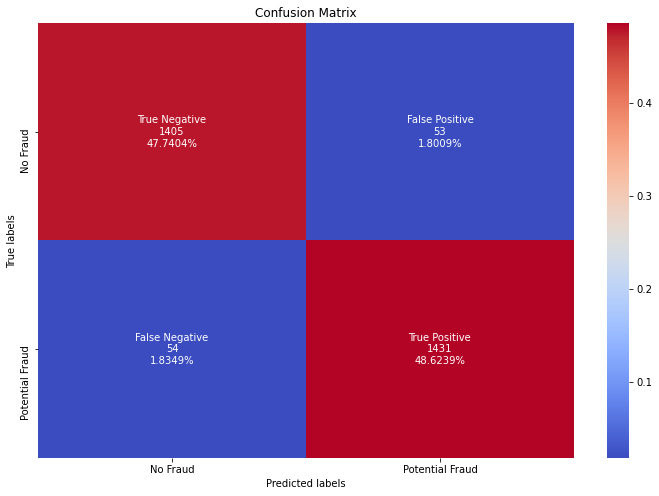

In [42]:
print(f'Accuracy Score: {accuracy_score(y_test_sm,predicted_test)}')
print('F1 Score: {}'.format(f1_score(y_test_sm, predicted_test)))
conf_mat(y_test_sm, predicted_test)

In [169]:
#XGBoost costs saved
print(f'XG Boost Model will save: ${round((Pos * .4876 * c - Pos * i - c * Neg*.0170)/.7*n, 2)}')
#Ensemble Model will save: $3445000.17

XG Boost Model will save: $3445000.17


In [37]:
XGB_top15_features = pd.DataFrame(zip(x.columns, list(xgb2.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)
XGB_top15_features

,feature,coef
19,diag_grp,0.324505
21,patient_duplicate_count,0.248629
18,claimdiag,0.057567
11,chronic_mean,0.054047
10,no_phy,0.051009
4,Race5,0.039091
3,Race3,0.034010
13,days_admitted,0.028042
20,duplicate_claims,0.021070
7,mean_age,0.018327


Text(0, 0.5, '')

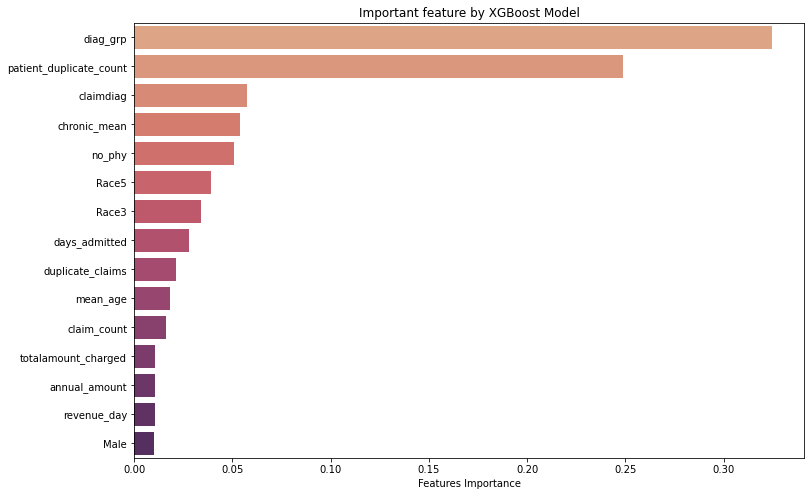

In [38]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=XGB_top15_features,palette="flare" )
ax.set_title('Important feature by XGBoost Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

In [28]:
# grid_search.fit(X_train_sm, y_train_sm)
# grid_search.best_params_
# {'max_depth': 80,
#  'max_features': 3,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 500}

In [45]:
#Random Forest
bestRF = RandomForestClassifier(max_depth= 50, max_features= 3, min_samples_leaf=3, min_samples_split=8,
                                n_estimators= 300)

In [46]:
bestRF.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=50, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=300)

In [47]:
predicted_test = bestRF.predict(X_test_sm)

Accuracy Score: 0.9384981311586816
F1 Score: 0.9400066291017568


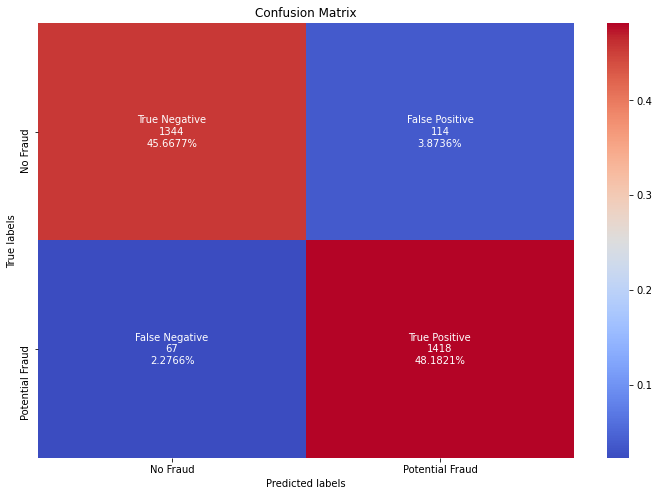

In [48]:
print(f'Accuracy Score: {accuracy_score(y_test_sm,predicted_test)}')
print('F1 Score: {}'.format(f1_score(y_test_sm, predicted_test)))
conf_mat(y_test_sm, predicted_test)

In [160]:
#Random Forest costs saved
# (number of true positive * c) - (false positive + true positive)* i  - (c * number false negatives)
print(f'Random Forest Model will save: ${round((Pos * .4815 * c - Pos * i - c * Neg*.0231)/.7*n, 2)}')

Random Forest Model will save: $1417256.21


In [49]:
RF_top15_features = pd.DataFrame(zip(x.columns, list(bestRF.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)
RF_top15_features

,feature,coef
19,diag_grp,0.130532
18,claimdiag,0.121202
23,outpatient,0.076832
1,Race1,0.057125
15,totalamount_charged,0.055889
5,Male,0.052581
6,Female,0.046990
16,revenue_day,0.044746
12,claim_count,0.042742
3,Race3,0.039456


Text(0, 0.5, '')

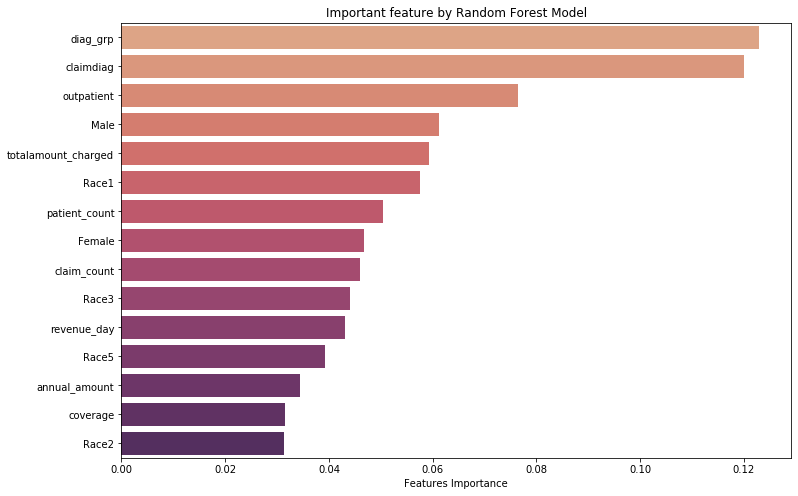

In [68]:
plt.rcParams['figure.figsize'] = (12,8)
ax = sns.barplot(x="coef", y="feature", data=RF_top15_features,palette="flare" )
ax.set_title('Important feature by Random Forest Model')
ax.set_xlabel('Features Importance')
ax.set_ylabel('')

# Ensemble

Accuracy Score: 0.9602446483180428
F1 Score: 0.9607514256960752


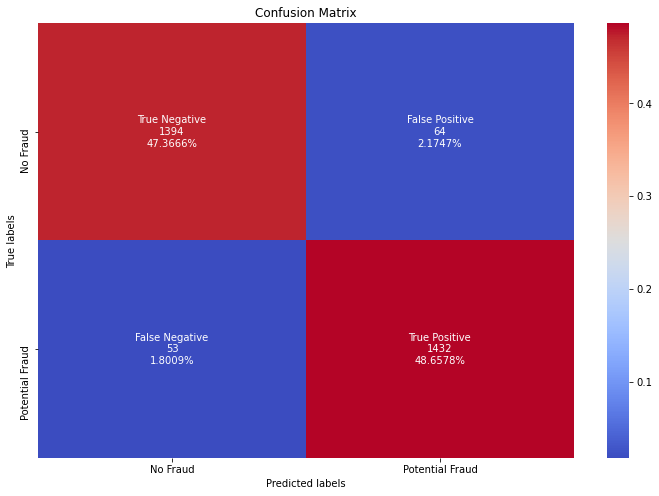

In [50]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[('GBC', gbc2), ('XGB', xgb2),('RF',bestRF)], voting='hard')
ensemble.fit(X_train_sm, y_train_sm)
y_pred = ensemble.predict(X_test_sm)

print(f'Accuracy Score: {accuracy_score(y_test_sm, y_pred)}')
print('F1 Score: {}'.format(f1_score(y_test_sm, y_pred)))
conf_mat(y_test_sm, y_pred)

In [177]:
#Ensemble cost saved
Ensemble_cost = Pos * .4876 * c - Pos * i - c * Neg*.0170
print(f'Ensemble Model will save: ${round(Ensemble_cost / .3 * n, 2)}')

Ensemble Model will save: $5230694.61


In [178]:
5230694.61/12

435891.2175

In [53]:
print('Ensemble')
print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test_sm, y_pred)))
       
print('Precision Score for test data: {:.3f}'.format(precision_score(y_test_sm, y_pred)))
       
print('Recall Score for test data: {:.3f}'.format(recall_score(y_test_sm, y_pred)))
       
print('f1 score for test data: {:.3f}'.format(f1_score(y_test_sm, y_pred)))
       
print('f2 score for test data: {:.3f}'.format(fbeta_score(y_test_sm, y_pred, beta = 2)))
       
print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test_sm, y_pred)))

Ensemble
Accuracy Score for test data: 0.960
Precision Score for test data: 0.957
Recall Score for test data: 0.964
f1 score for test data: 0.961
f2 score for test data: 0.963
ROC-AUC Score for test data: 0.960


In [ ]:
# model_rmse = [rmse_cv_test(lasso).mean(), rmse_cv_test(enet).mean(), rmse_cv_test(ridge).mean(),rmse_cv_test(xgb2).mean(),
#                 rmse_cv_test(gb).mean(), rmse_cv_test(rf).mean(), rmse_cv_test(lr).mean(), rmse_cv_test(dt).mean()]
# models = ['Lasso','eNet','Ridge','XGBoost','GBoost','RanFor','MLR','DecTr']

# f, ax = plt.subplots()
# a = sns.barplot(x=models, y=model_rmse)
# for bar in a.patches:
#     a.annotate(format(bar.get_height(), '.4f'), 
#                    (bar.get_x() + bar.get_width()/2., bar.get_height()), 
#                    ha ='center', va ='center', 
#                    xytext = (0, 8), 
#                    textcoords = 'offset points')
# plt.ylim(0, 0.23)
# ax.set(ylabel="RMSE",xlabel="Model", title="Root Mean Square Error by Model")